In [308]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random


from termcolor import colored

from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

# Model
# --------------------------------------------------------------------
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import metrics

In [309]:
def metricas(validacion, prediccion, churm):
    
    print("Exactitud: ", metrics.accuracy_score(validacion, prediccion))
    print("Kappa: ", metrics.cohen_kappa_score(validacion, prediccion))
    
    print(colored('Metricas de los registros mineros', attrs=['bold']))
    
    print("Precisión: ",  metrics.precision_score(validacion, prediccion, labels=[1], average='macro'))
    print("Recall: ",  metrics.recall_score(validacion, prediccion, labels=[1], average='macro'))
    
    VP = np.sum(churm[1:2,1:2])
    FN = np.sum(churm[1,0:1])
    specificity = VP/(VP+FN)
    
    print("Especificidad : ", specificity)
    print("F1-score      : ", metrics.f1_score(validacion, prediccion, labels=[1], average='macro'))
    
    
    print(colored('Metricas de los registros no mineros', attrs=['bold']))
    
    print("Precisión: ",  metrics.precision_score(validacion, prediccion, labels=[0], average='macro'))
    print("Recall: ",  metrics.recall_score(validacion, prediccion, labels=[0], average='macro'))
    
    VP = np.sum(churm[0:1,0:1])
    FN = np.sum(churm[0,1:2])
    specificity = VP/(VP+FN)
    
    print("Especificidad : ", specificity)
    print("F1-score      : ", metrics.f1_score(validacion, prediccion, labels=[0], average='macro'))

In [310]:
def matriz_confusion(validacion, prediccion, cmap):
    print(colored('Matriz de confusión', attrs=['bold']))
    churm = metrics.confusion_matrix(validacion, prediccion)
    plt.imshow(churm, cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Not_mine','Mine'])
    plt.yticks(tick_marks, ['Not_mine','Mine'])
    return churm

# Importar datos Puros

In [311]:
dataA = pd.read_csv('./data_identificada.csv').drop(['Second_Protocol', 'Third_Protocol'], axis = 1)
dataA.head(1)

,Netflows,First_Protocol,p1_d,p2_d,p3_d,duration,max_d,min_d,#packets,Avg_bps,...,second_dp,third_dp,p1_ip,p2_ip,p3_ip,p1_ib,p2_ib,p3_ib,Type,Cryptocurrency
0,168,TCP,0.0,0.0,3.00375,1354.823,60.004,0.0,5335,212962,...,80.0,53.0,1.0,1.0,2.0,32.0,32.0,64.0,not_mine,Does not have


# Preprocesamiento

### Imputación de valores ausentes

In [312]:
punter = pd.concat([dataA['second_sp'],dataA['second_dp'],dataA['third_sp'],dataA['third_dp']],axis=1)
imputer = SimpleImputer(missing_values = np.nan, strategy = "median")
values = imputer.fit_transform(punter)

In [313]:
punter = pd.DataFrame(values, columns = punter.columns)
dataA['second_sp'] = punter['second_sp']
dataA['second_dp'] = punter['second_dp']
dataA['third_sp'] = punter['third_sp']
dataA['third_dp'] = punter['third_dp']

In [314]:
dataCopyA = dataA
dataA.shape

(4733, 29)

In [315]:
print(colored('Como los registros benignos son los mismos para cada conjunto de datos, sacare aleatoriamente el 70% para utilizarlos para el entreno de modelos posteriores, y emular con el 30% datos de testeo', attrs=['bold']))
porcion_no_minera_conjuntoA = dataCopyA[dataCopyA.Type == "not_mine"]
porcion_no_minera_conjuntoA = porcion_no_minera_conjuntoA.sample(n=750)

Como los registros benignos son los mismos para cada conjunto de datos, sacare aleatoriamente el 70% para utilizarlos para el entreno de modelos posteriores, y emular con el 30% datos de testeo


In [316]:
dataA = dataA[~dataA.index.isin(porcion_no_minera_conjuntoA.index)]

### OneHotEncoder

In [317]:
data_categoric = dataA[dataA.select_dtypes(include = ['object']).columns.to_list()]
one_hot = OneHotEncoder()
one_hot.fit_transform(data_categoric)

<3983x11 sparse matrix of type '<class 'numpy.float64'>'
	with 11949 stored elements in Compressed Sparse Row format>

In [318]:
data_dummy = pd.get_dummies(data_categoric)
data_dummy.head(2)

,First_Protocol_ICMP,First_Protocol_TCP,First_Protocol_UDP,Type_mine,Type_not_mine,Cryptocurrency_Bitcash,Cryptocurrency_Bitcoin,Cryptocurrency_Does not have,Cryptocurrency_Etherium,Cryptocurrency_Litecoin,Cryptocurrency_Monero
0,0,1,0,0,1,0,0,1,0,0,0
1,0,1,0,0,1,0,0,1,0,0,0


### Estructuración

In [319]:
dataA = dataA.drop(data_categoric, axis = 1)
dataA.columns

Index(['Netflows', 'p1_d', 'p2_d', 'p3_d', 'duration', 'max_d', 'min_d',
       '#packets', 'Avg_bps', 'Avg_pps', 'Avg_bpp', '#Bytes', '#sp', '#dp',
       'first_sp', 'second_sp', 'third_sp', 'first_dp', 'second_dp',
       'third_dp', 'p1_ip', 'p2_ip', 'p3_ip', 'p1_ib', 'p2_ib', 'p3_ib'],
      dtype='object')

In [320]:
dataA = pd.concat([dataA,data_dummy], axis = 1)
dataA.columns

Index(['Netflows', 'p1_d', 'p2_d', 'p3_d', 'duration', 'max_d', 'min_d',
       '#packets', 'Avg_bps', 'Avg_pps', 'Avg_bpp', '#Bytes', '#sp', '#dp',
       'first_sp', 'second_sp', 'third_sp', 'first_dp', 'second_dp',
       'third_dp', 'p1_ip', 'p2_ip', 'p3_ip', 'p1_ib', 'p2_ib', 'p3_ib',
       'First_Protocol_ICMP', 'First_Protocol_TCP', 'First_Protocol_UDP',
       'Type_mine', 'Type_not_mine', 'Cryptocurrency_Bitcash',
       'Cryptocurrency_Bitcoin', 'Cryptocurrency_Does not have',
       'Cryptocurrency_Etherium', 'Cryptocurrency_Litecoin',
       'Cryptocurrency_Monero'],
      dtype='object')

# Árbol de decisión

Mejores caracteristicas del conjunto de datos puros

In [321]:
best_feature_sel = ['#dp', '#sp', 'first_dp', 'first_sp', 'min_d', 'p1_d', 'p1_ip',
       'p2_d', 'p2_ip', 'p3_ib', 'second_dp', 'second_sp']

In [322]:
X = dataA[best_feature_sel]
y = dataA['Type_mine']

### Holdout

In [323]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.7)

### Modelo

In [324]:
print(colored('Instancio el modelo de arbol de decisión', attrs=['bold']))
model = DecisionTreeClassifier(
    criterion='entropy', 
    max_depth=5,      
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=None,  
    max_leaf_nodes=None, 
    min_impurity_decrease=0.0, 
    class_weight=None)

Instancio el modelo de arbol de decisión


In [325]:
print(colored('Entreno el modelo', attrs=['bold']))
model.fit(X_train,y_train)

Entreno el modelo


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

Grafico el modelo
Profundidad del árbol: 4
Número de nodos terminales: 5


[Text(159.42857142857142, 489.24, 'first_sp <= 1887.5\nsamples = 2788\nvalue = [1212, 1576]\nclass = i'),
 Text(79.71428571428571, 380.52000000000004, 'samples = 1193\nvalue = [1193, 0]\nclass = T'),
 Text(239.1428571428571, 380.52000000000004, 'second_dp <= 2616.0\nsamples = 1595\nvalue = [19, 1576]\nclass = i'),
 Text(159.42857142857142, 271.8, 'samples = 16\nvalue = [16, 0]\nclass = T'),
 Text(318.85714285714283, 271.8, '#sp <= 3.5\nsamples = 1579\nvalue = [3, 1576]\nclass = i'),
 Text(239.1428571428571, 163.08000000000004, 'samples = 1564\nvalue = [0, 1564]\nclass = i'),
 Text(398.57142857142856, 163.08000000000004, 'second_sp <= 47688.5\nsamples = 15\nvalue = [3, 12]\nclass = i'),
 Text(318.85714285714283, 54.360000000000014, 'samples = 3\nvalue = [3, 0]\nclass = T'),
 Text(478.2857142857142, 54.360000000000014, 'samples = 12\nvalue = [0, 12]\nclass = i')]

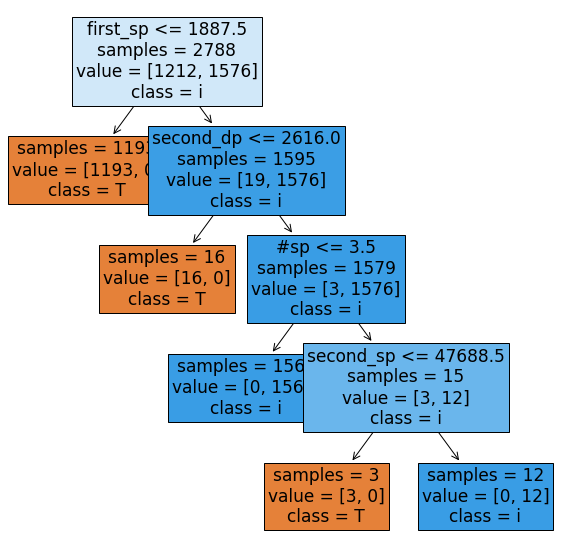

In [326]:
print(colored('Grafico el modelo', attrs=['bold']))
fig, ax = plt.subplots(figsize = (10,10))

print(colored(f'Profundidad del árbol: {model.get_depth()}', attrs=['bold']))
print(colored(f'Número de nodos terminales: {model.get_n_leaves()}', attrs=['bold']))


plot_tree(
    decision_tree = model,
    feature_names = X_train.columns.tolist(),
    class_names   = 'Tipo de trafico minero',
    filled        = True,
    impurity      = False,
    fontsize      = 17,
    ax            = ax
)

In [327]:
print(colored('Realizo la predicción del modelo con la porción de prueba', attrs=['bold']))
y_pred = model.predict(X_test)
y_pred

Realizo la predicción del modelo con la porción de prueba


array([0, 0, 1, ..., 1, 0, 0], dtype=uint8)

In [328]:
len(y_pred[y_pred == 0])

537

In [329]:
len(y_pred[y_pred == 1])

658

### Métricas y matriz de confusión

Matriz de confusión


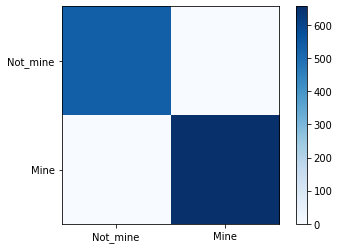

In [330]:
churm = matriz_confusion(y_test, y_pred, plt.cm.Blues)

In [331]:
pd.DataFrame(churm)

,0,1
0,537,2
1,0,656


In [332]:
metricas(y_test, y_pred, churm)

Exactitud:  0.998326359832636
Kappa:  0.9966192034900004
Metricas de los registros mineros
Precisión:  0.9969604863221885
Recall:  1.0
Especificidad :  1.0
F1-score      :  0.9984779299847794
Metricas de los registros no mineros
Precisión:  1.0
Recall:  0.9962894248608535
Especificidad :  0.9962894248608535
F1-score      :  0.9981412639405204


# Experimento 1

In [333]:
print(colored('Importo el conjunto de datos no puros', attrs=['bold']))
dataB = pd.read_csv('./data_no_identificada.csv').drop(['Name','Second_Protocol', 'Third_Protocol'], axis = 1)
dataB.columns

Importo el conjunto de datos no puros


Index(['Netflows', 'First_Protocol', 'p1_d', 'p2_d', 'p3_d', 'duration',
       'max_d', 'min_d', '#packets', 'Avg_bps', 'Avg_pps', 'Avg_bpp', '#Bytes',
       '#sp', '#dp', 'first_sp', 'second_sp', 'third_sp', 'first_dp',
       'second_dp', 'third_dp', 'p1_ip', 'p2_ip', 'p3_ip', 'p1_ib', 'p2_ib',
       'p3_ib', 'Type'],
      dtype='object')

In [334]:
porcion_no_minera_conjuntoA = porcion_no_minera_conjuntoA.drop('Cryptocurrency', axis = 1)

In [335]:
dataB = pd.concat([dataB[dataB.Type == 'mine'],porcion_no_minera_conjuntoA], axis = 0)

In [336]:
dataB.columns

Index(['Netflows', 'First_Protocol', 'p1_d', 'p2_d', 'p3_d', 'duration',
       'max_d', 'min_d', '#packets', 'Avg_bps', 'Avg_pps', 'Avg_bpp', '#Bytes',
       '#sp', '#dp', 'first_sp', 'second_sp', 'third_sp', 'first_dp',
       'second_dp', 'third_dp', 'p1_ip', 'p2_ip', 'p3_ip', 'p1_ib', 'p2_ib',
       'p3_ib', 'Type'],
      dtype='object')

In [337]:
print(colored('Valores faltantes del conjunto no puro', attrs=['bold']))
dataB.isnull().sum()

Valores faltantes del conjunto no puro


Netflows              0
First_Protocol        0
p1_d                  0
p2_d                  0
p3_d                  0
duration              0
max_d                 0
min_d                 0
#packets              0
Avg_bps               0
Avg_pps               0
Avg_bpp               0
#Bytes                0
#sp                   0
#dp                   0
first_sp              0
second_sp          7495
third_sp          10953
first_dp              0
second_dp          1705
third_dp           7064
p1_ip                 0
p2_ip                 0
p3_ip                 0
p1_ib                 0
p2_ib                 0
p3_ib                 0
Type                  0
dtype: int64

### Imputar valores

In [338]:
punter = pd.concat([dataB['second_sp'],dataB['third_sp'],dataB['second_dp'],dataB['third_dp']], axis = 1)
imputer = SimpleImputer(missing_values = np.nan, strategy = 'median')
values = imputer.fit_transform(punter)

In [339]:
punter = pd.DataFrame(values, columns = punter.columns)
dataB['second_sp'] = punter['second_sp']
dataB['second_dp'] = punter['second_dp']
dataB['third_sp'] = punter['third_sp']
dataB['third_dp'] = punter['third_dp']

In [340]:
X = dataB[best_feature_sel]
y = dataB['Type'].replace({'mine':1,'not_mine':0})

In [341]:
y_pred = model.predict(X)
y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

Matriz de confusión


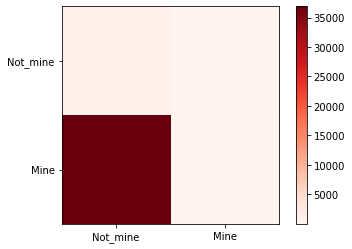

In [342]:
churm = matriz_confusion(y, y_pred, plt.cm.Reds)

In [343]:
pd.DataFrame(churm)

,0,1
0,748,2
1,36874,179


In [344]:
metricas(y, y_pred, churm)

Exactitud:  0.024521863344179034
Kappa:  8.628091825779727e-05
Metricas de los registros mineros
Precisión:  0.988950276243094
Recall:  0.004830917874396135
Especificidad :  0.004830917874396135
F1-score      :  0.009614868131277864
Metricas de los registros no mineros
Precisión:  0.019881983945563765
Recall:  0.9973333333333333
Especificidad :  0.9973333333333333
F1-score      :  0.0389867611800271


# Experimento 2

In [345]:
print(colored('Caracteristicas del conjunto de datos puro', attrs=['bold']))
print(best_feature_sel)

Caracteristicas del conjunto de datos puro
['#dp', '#sp', 'first_dp', 'first_sp', 'min_d', 'p1_d', 'p1_ip', 'p2_d', 'p2_ip', 'p3_ib', 'second_dp', 'second_sp']


In [346]:
print(colored('Caracteristicas del conjunto de datos no puro', attrs=['bold']))
best_feature_noPure = ['#dp', '#packets', '#sp', 'duration', 'first_dp', 'first_sp',
       'max_d', 'min_d', 'p1_d', 'p1_ib', 'p2_d', 'p2_ib', 'p3_d',
       'p3_ib', 'second_dp', 'second_sp', 'third_sp','Type_mine']
print(best_feature_noPure)

Caracteristicas del conjunto de datos no puro
['#dp', '#packets', '#sp', 'duration', 'first_dp', 'first_sp', 'max_d', 'min_d', 'p1_d', 'p1_ib', 'p2_d', 'p2_ib', 'p3_d', 'p3_ib', 'second_dp', 'second_sp', 'third_sp', 'Type_mine']


In [347]:
print(colored('Combino las caracteristicas', attrs=['bold']))
bestFeature = np.concatenate([best_feature_sel,best_feature_noPure])
bestFeature = np.unique(bestFeature)
bestFeature

Combino las caracteristicas


array(['#dp', '#packets', '#sp', 'Type_mine', 'duration', 'first_dp',
       'first_sp', 'max_d', 'min_d', 'p1_d', 'p1_ib', 'p1_ip', 'p2_d',
       'p2_ib', 'p2_ip', 'p3_d', 'p3_ib', 'second_dp', 'second_sp',
       'third_sp'], dtype='<U9')

In [348]:
print(colored('Aplico una tecnica de submuestreo para equilibrar las clases del conjunto de datos no puros,  con la finalidad de balanciar el conjunto de datos', attrs=['bold']))
porcion_minera_conjuntoB = dataB[dataB.Type == "mine"]
porcion_minera_conjuntoB = porcion_minera_conjuntoB.sample(n=dataCopyA[dataCopyA.Type == "mine"].shape[0])

Aplico una tecnica de submuestreo para equilibrar las clases del conjunto de datos no puros,  con la finalidad de balanciar el conjunto de datos


In [349]:
print(colored('Unimos los conjuntos de datos y aplicamos aleatoriedad en la posición de los registros', attrs=['bold']))


Unimos los conjuntos de datos y aplicamos aleatoriedad en la posición de los registros


In [350]:
copy_porcion_minera_conjuntoB = porcion_minera_conjuntoB 

In [351]:
porcion_minera_conjuntoB = porcion_minera_conjuntoB.rename(columns = {'Type':'Type_mine'})
porcion_minera_conjuntoB['Type_mine'] = porcion_minera_conjuntoB['Type_mine'].replace({'mine':1,'not_mine':0})

In [352]:
data_final = pd.concat([dataA[bestFeature], porcion_minera_conjuntoB[bestFeature]], axis = 0)
data_final.shape

(6215, 20)

In [353]:
print(colored('Aleatoriedad', attrs=['bold']))
data_final = data_final.reset_index()
indices = list(data_final.index)
random.shuffle(indices)
data_final = data_final.reindex(indices)
data_final.head()

Aleatoriedad


,index,#dp,#packets,#sp,Type_mine,duration,first_dp,first_sp,max_d,min_d,...,p1_ib,p1_ip,p2_d,p2_ib,p2_ip,p3_d,p3_ib,second_dp,second_sp,third_sp
1254,1465,2,38,2,1,538.811,51085,51085,269.442,269.369,...,1686.50,19.0,269.4055,1803.0,19.0,269.42375,1919.50,14444.0,14444.0,123.0
648,757,19,189,24,0,3595.161,443,443,194.962,0.000,...,77.00,2.5,121.8560,160.0,4.0,149.95300,280.00,1900.0,123.0,80.0
3463,4101,38,349,41,0,6174.986,443,443,165.084,0.000,...,93.75,3.0,90.1140,128.0,4.0,112.08800,216.00,123.0,123.0,80.0
4467,33952,8,76,12,1,1172.944,1900,0,360.014,0.000,...,32.00,1.0,0.0000,144.0,1.0,3.00100,500.50,34560.0,5353.0,56508.0
1528,1786,2,351,2,1,522.541,4444,4444,42.625,0.000,...,321.50,3.0,10.0560,548.0,9.5,19.44075,2211.75,58780.0,58780.0,123.0


In [354]:
data_final.drop(['index'],axis =1, inplace=True)

In [355]:
data_final['Type_mine'] = data_final['Type_mine'].astype('int')

In [356]:
data_final.shape

(6215, 20)

### Modelo

In [357]:
X = data_final.drop('Type_mine', axis = 1)
y = data_final['Type_mine']

In [358]:
model = DecisionTreeClassifier(
    criterion='entropy', 
    max_depth=5,      
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=None,  
    max_leaf_nodes=None, 
    min_impurity_decrease=0.0, 
    class_weight=None)

In [359]:
scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']
scores = cross_validate(model, X, y, scoring=scoring, cv=10, return_train_score=False)

for key in scores:
    score = scores[key]
    print("%s: %0.2f (+/- %0.2f)" % (key, score.mean(), score.std() * 2))


fit_time: 0.16 (+/- 0.03)
score_time: 0.02 (+/- 0.00)
test_accuracy: 1.00 (+/- 0.00)
test_precision_weighted: 1.00 (+/- 0.00)
test_recall_weighted: 1.00 (+/- 0.00)
test_f1_weighted: 1.00 (+/- 0.00)


In [360]:
K_fold = KFold(n_splits = 10)

In [361]:
resultados_train = []
resultados_test = []
predicciones = []
scores = []
modelos = []


for result in K_fold.split(X):
    resultados_train.append(result[0])
    resultados_test.append(result[1])
    X_train = X.iloc[result[0]]
    X_test =  X.iloc[result[1]]
    y_train =  y.iloc[result[0]]
    y_test =  y.iloc[result[1]]
    model = model.fit(X_train,y_train)
    modelos.append(model)
    predic = model.predict(X_test)
    predicciones.append(predic)
    scores.append(model.score(X_test, y_test))

In [362]:
scores

[0.9967845659163987,
 0.9967845659163987,
 0.9903536977491961,
 0.9967845659163987,
 0.9935691318327974,
 0.9967793880837359,
 0.9967793880837359,
 0.9951690821256038,
 0.9951690821256038,
 0.998389694041868]

Matriz de confusión


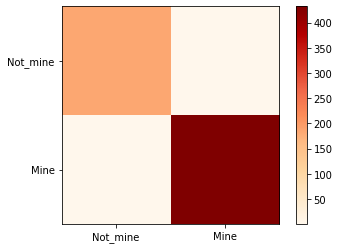

In [363]:
churm = matriz_confusion(y.iloc[resultados_test[7]], predicciones[7], plt.cm.OrRd)

In [364]:
pd.DataFrame(churm)

,0,1
0,186,1
1,2,432


In [365]:
metricas(y.iloc[resultados_test[7]], predicciones[7], churm)

Exactitud:  0.9951690821256038
Kappa:  0.988539827636055
Metricas de los registros mineros
Precisión:  0.9976905311778291
Recall:  0.9953917050691244
Especificidad :  0.9953917050691244
F1-score      :  0.9965397923875432
Metricas de los registros no mineros
Precisión:  0.9893617021276596
Recall:  0.9946524064171123
Especificidad :  0.9946524064171123
F1-score      :  0.9919999999999999


### Prueba final

In [366]:
porcion_no_minera_conjuntoA.columns

Index(['Netflows', 'First_Protocol', 'p1_d', 'p2_d', 'p3_d', 'duration',
       'max_d', 'min_d', '#packets', 'Avg_bps', 'Avg_pps', 'Avg_bpp', '#Bytes',
       '#sp', '#dp', 'first_sp', 'second_sp', 'third_sp', 'first_dp',
       'second_dp', 'third_dp', 'p1_ip', 'p2_ip', 'p3_ip', 'p1_ib', 'p2_ib',
       'p3_ib', 'Type'],
      dtype='object')

In [367]:
copy_porcion_minera_conjuntoB.columns

Index(['Netflows', 'First_Protocol', 'p1_d', 'p2_d', 'p3_d', 'duration',
       'max_d', 'min_d', '#packets', 'Avg_bps', 'Avg_pps', 'Avg_bpp', '#Bytes',
       '#sp', '#dp', 'first_sp', 'second_sp', 'third_sp', 'first_dp',
       'second_dp', 'third_dp', 'p1_ip', 'p2_ip', 'p3_ip', 'p1_ib', 'p2_ib',
       'p3_ib', 'Type'],
      dtype='object')

In [368]:
prueba_final.shape

(36271, 28)

In [369]:
dataB = dataB[~dataB.index.isin(porcion_minera_conjuntoB.index)]

In [370]:
prueba_final = pd.concat([porcion_no_minera_conjuntoA,dataB], axis = 0)

In [371]:
bestFeature = ['#dp', '#packets', '#sp', 'duration', 'first_dp',
       'first_sp', 'max_d', 'min_d', 'p1_d', 'p1_ib', 'p1_ip', 'p2_d',
       'p2_ib', 'p2_ip', 'p3_d', 'p3_ib', 'second_dp', 'second_sp',
       'third_sp']

In [372]:
X_p = prueba_final[bestFeature]
y_p = prueba_final['Type'].replace({'mine':1,'not_mine':0})

In [373]:
y_pred_proba = modelos[0].predict(X_p)

Matriz de confusión


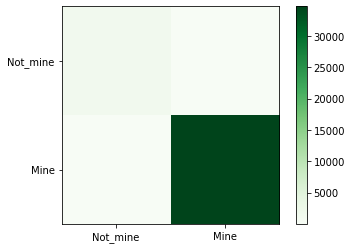

In [374]:
churm = matriz_confusion(y_p, y_pred_proba, plt.cm.Greens)

In [375]:
pd.DataFrame(churm)

,0,1
0,1415,34
1,126,34695


In [376]:
metricas(y_p, y_pred_proba, churm)

Exactitud:  0.995588640749931
Kappa:  0.9441900626113408
Metricas de los registros mineros
Precisión:  0.9990209911025368
Recall:  0.9963814939260791
Especificidad :  0.9963814939260791
F1-score      :  0.9976994967649174
Metricas de los registros no mineros
Precisión:  0.918234912394549
Recall:  0.9765355417529331
Especificidad :  0.9765355417529331
F1-score      :  0.9464882943143813


In [377]:
y_pred_proba = model.predict_proba(X_test)

In [378]:
lr_probs = y_pred_proba[:,1]

In [379]:
ns_probs = [0 for _ in range(len(y_test))]

In [380]:
ns_auc = metrics.roc_auc_score(y_test, ns_probs)
ns_auc

0.5

In [381]:
lr_auc = metrics.roc_auc_score(y_test, lr_probs)
lr_auc

0.998819669749649

In [382]:
#Sumo los scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Treeb: ROC AUC=%.3f' % (lr_auc))

No Skill: ROC AUC=0.500
Treeb: ROC AUC=0.999


In [383]:
ns_fpr, ns_tpr, thresholds  = metrics.roc_curve(y_test,ns_probs)
lr_fpr, lr_tpr, thresholds = metrics.roc_curve(y_test, lr_probs)

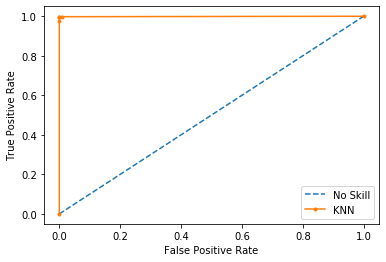

In [384]:
#Plot la roc curva para el modelo
plt.plot(ns_fpr,ns_tpr,linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='KNN')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

Holdaunt 70% pero debo hacer una validadci{on cruzada en este conjunto de entrenamiento (Puros), de este cruz validation saldra un modelo, y lo testeo con el 30%, con este porcentaje, le saco las metricas